In [37]:
## Import libraries

import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix,classification_report

In [38]:
## I use 64x64 grayscale images represented into a CSV

data = pd.read_csv("../input/hmnist_64_64_L.csv")

In [39]:
## Let's look the data

data.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,pixel0010,pixel0011,pixel0012,pixel0013,pixel0014,pixel0015,pixel0016,pixel0017,pixel0018,pixel0019,pixel0020,pixel0021,pixel0022,pixel0023,pixel0024,pixel0025,pixel0026,pixel0027,pixel0028,pixel0029,pixel0030,pixel0031,pixel0032,pixel0033,pixel0034,pixel0035,pixel0036,pixel0037,pixel0038,pixel0039,...,pixel4057,pixel4058,pixel4059,pixel4060,pixel4061,pixel4062,pixel4063,pixel4064,pixel4065,pixel4066,pixel4067,pixel4068,pixel4069,pixel4070,pixel4071,pixel4072,pixel4073,pixel4074,pixel4075,pixel4076,pixel4077,pixel4078,pixel4079,pixel4080,pixel4081,pixel4082,pixel4083,pixel4084,pixel4085,pixel4086,pixel4087,pixel4088,pixel4089,pixel4090,pixel4091,pixel4092,pixel4093,pixel4094,pixel4095,label
0,134,99,119,130,142,169,152,139,117,87,67,76,72,56,150,171,159,150,152,151,189,206,163,152,110,68,120,185,206,186,111,103,123,151,198,207,179,190,197,191,...,119,70,46,103,186,154,172,133,77,58,44,68,104,101,102,127,131,135,140,101,83,38,49,52,44,105,121,129,156,146,112,89,73,100,120,120,126,140,195,2
1,55,64,74,63,74,75,71,73,70,77,88,77,64,47,41,56,56,56,71,100,95,78,73,81,82,77,63,48,53,49,52,71,94,94,79,89,93,78,82,75,...,69,75,83,71,71,73,79,84,78,71,67,64,63,66,56,60,58,51,48,53,49,50,53,54,62,66,72,70,71,76,79,85,86,77,68,66,65,68,69,2
2,114,116,136,152,132,100,151,150,127,205,196,133,122,114,97,133,139,89,66,64,67,113,124,97,76,69,65,79,69,89,100,115,203,203,167,179,107,75,93,88,...,123,100,109,138,110,109,123,130,105,113,118,107,76,91,127,112,68,53,65,80,98,97,97,147,153,128,153,121,132,144,128,157,159,205,182,143,129,89,122,2
3,86,82,88,85,103,93,98,109,104,115,147,94,98,106,104,89,59,53,64,70,77,105,83,91,94,94,86,78,97,118,125,108,92,84,56,58,79,82,91,99,...,89,93,115,117,48,83,80,106,126,112,71,89,128,134,140,123,166,172,124,123,139,138,97,91,95,114,98,75,81,75,79,80,109,128,89,85,80,63,48,2
4,168,143,140,139,129,123,123,141,137,101,96,93,126,134,118,104,105,103,103,93,111,91,98,112,91,95,151,160,139,152,151,143,163,191,172,159,121,95,116,103,...,107,93,125,146,95,146,158,108,112,120,127,122,108,96,100,135,171,157,121,101,113,127,110,99,143,186,187,177,177,201,231,199,183,195,179,134,142,158,149,2


In [40]:
## Let's look the shape

data.shape

(5000, 4097)

In [41]:
# Splitting labels and features

Y = data["label"]
data.drop(["label"],axis=1, inplace=True)
X = data

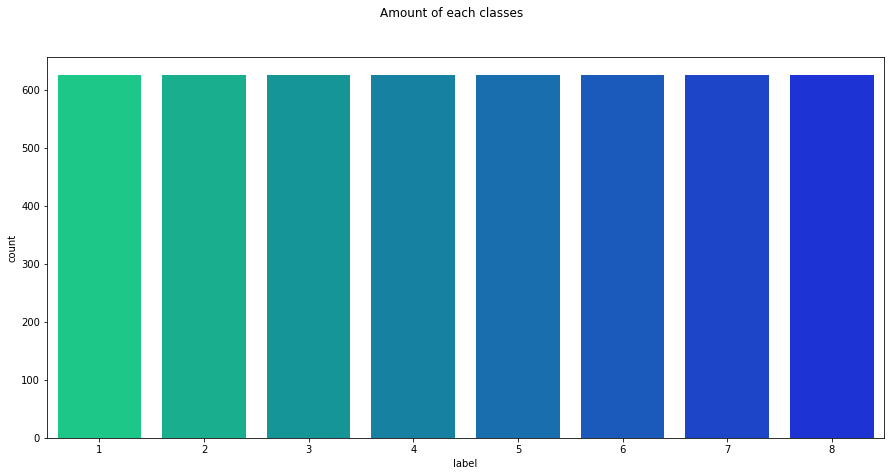

In [42]:
# And creating a countplot

plt.figure(figsize=(15,7))
g = sns.countplot(Y, palette="winter_r")
plt.suptitle("Amount of each classes")
plt.show()

In [43]:
## The dataset is well balanced (probably perfect)

Y.value_counts()        

7    625
3    625
6    625
2    625
5    625
1    625
8    625
4    625
Name: label, dtype: int64

In [44]:
## Manual scaling

X = X / 255.0     

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


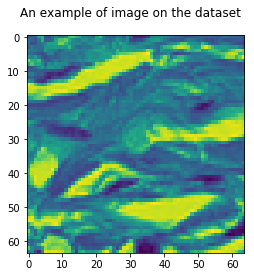

In [45]:
## Looking for an example image

img = X.iloc[75].as_matrix()
img = img.reshape(64,64)
plt.imshow(img)
plt.suptitle("An example of image on the dataset")
plt.show()

In [46]:
## Reshaping images for the CNN

X = X.values.reshape(-1,64,64,1)     
Y = Y.values

In [47]:
## Label Encoding into One-Hot

from keras.utils.np_utils import to_categorical 
Y = to_categorical(Y)

In [48]:
## Train and test splitting

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)

In [49]:
## Printing shapes

print("X_train.shape: ",X_train.shape)
print("X_test.shape: ",X_test.shape)
print("y_train.shape: ",y_train.shape)
print("y_test.shape: ",y_test.shape)

X_train.shape:  (4000, 64, 64, 1)
X_test.shape:  (1000, 64, 64, 1)
y_train.shape:  (4000, 9)
y_test.shape:  (1000, 9)


<h1> CNN CREATION

In [50]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size = (5,5),padding = 'same',activation ='relu', input_shape = (64,64,1)))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'same',activation ='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'same',activation ='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(256,activation = "relu"))          
model.add(tf.keras.layers.Dense(64,activation = "relu"))
model.add(tf.keras.layers.Dense(32,activation = "elu"))

model.add(tf.keras.layers.Dense(9, activation = "softmax"))

In [51]:
## Let's print the summary of the model

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 64, 64, 128)       3328      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 64)        73792     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 64)        36928     
__________

In [52]:
## And compile it

model.compile(optimizer = "Adam" , loss = "binary_crossentropy", metrics=["accuracy"])

In [53]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=0.5, 
        zoom_range = 0.5, 
        width_shift_range=0.5,  
        height_shift_range=0.5, 
        horizontal_flip=True, 
        vertical_flip=True)

datagen.fit(X_train)

In [54]:
## Model training

EPOCHS = 50
BATCH_SIZE = 32


hist = model.fit_generator(datagen.flow(X_train,y_train, batch_size=BATCH_SIZE),
                              epochs = EPOCHS, validation_data = (X_test,y_test))

Epoch 1/50
125/125 [==============================] - 5s 37ms/step - loss: 0.2636 - acc: 0.8917 - val_loss: 0.2230 - val_acc: 0.8949
Epoch 2/50
125/125 [==============================] - 2s 17ms/step - loss: 0.2225 - acc: 0.8945 - val_loss: 0.2350 - val_acc: 0.8908
Epoch 3/50
125/125 [==============================] - 2s 17ms/step - loss: 0.2059 - acc: 0.9033 - val_loss: 0.2242 - val_acc: 0.8914
Epoch 4/50
125/125 [==============================] - 3s 20ms/step - loss: 0.2006 - acc: 0.9062 - val_loss: 0.1882 - val_acc: 0.9059
Epoch 5/50
125/125 [==============================] - 2s 17ms/step - loss: 0.1955 - acc: 0.9098 - val_loss: 0.1763 - val_acc: 0.9174
Epoch 6/50
125/125 [==============================] - 2s 17ms/step - loss: 0.1906 - acc: 0.9112 - val_loss: 0.1907 - val_acc: 0.9078
Epoch 7/50
125/125 [==============================] - 2s 17ms/step - loss: 0.1858 - acc: 0.9138 - val_loss: 0.1835 - val_acc: 0.9251
Epoch 8/50
125/125 [==============================] - 2s 17ms/step - 

In [55]:
#à Predict the values from the validation dataset
y_pred = model.predict(X_test)


## Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 


## Convert validation observations to one hot vectors
y_true = np.argmax(y_test,axis = 1) 


## Compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 

## Compute loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test,  y_test, verbose=2)

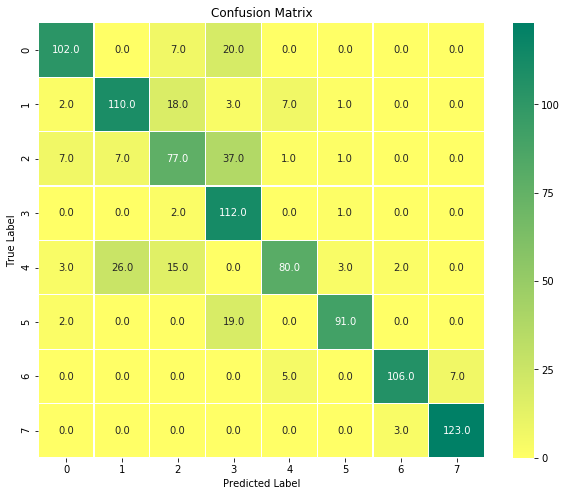

In [56]:
## Plot the confusion matrix

f,ax = plt.subplots(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="summer_r", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [57]:
## Print accuracy and loss

print(f"Accuracy: {test_accuracy}\nLoss: {test_loss}")

Accuracy: 0.9568888683319092
Loss: 0.11392411041259766
